# Setup

## Imports

In [196]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import time

In [197]:
cv2.__version__, np.__version__

('4.10.0', '1.26.4')

## Download

In [198]:
if not os.path.exists('video_teste02.mp4'):
  print('Downloading video_teste02.mp4...')
  !wget https://github.com/gabevr/yolo/raw/master/videos/video_teste02.mp4

In [199]:
if not os.path.exists('yolov4.weights'):
  print('Downloading yolov4.weights...')
  !wget https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v3_optimal/yolov4.weights

In [200]:
if not os.path.exists('yolov4.cfg'):
  print('Downloading yolov4.cfg...')
  !wget https://raw.githubusercontent.com/Tianxiaomo/pytorch-YOLOv4/refs/heads/master/cfg/yolov4.cfg

In [201]:
if not os.path.exists('coco.names'):
  print('Downloading coc.names...')
  !wget https://raw.githubusercontent.com/Tianxiaomo/pytorch-YOLOv4/refs/heads/master/data/coco.names

# Model configuration

In [202]:
path_weights = 'yolov4.weights'
path_cfg = 'yolov4.cfg'
path_names = 'coco.names'

In [203]:
names = []
with open(path_names, 'r') as f:
  names = f.read().strip().split('\n')

In [204]:
colors = np.random.uniform(0, 255, size=(len(names), 3))
colors = colors.astype(int)
colors = colors.tolist()

In [205]:
net = cv2.dnn.readNet(path_weights, path_cfg)
layer_names = net.getLayerNames()
output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers()]
output_layers

['yolo_139', 'yolo_150', 'yolo_161']

# frame preprocessing

In [206]:
video = cv2.VideoCapture('video_teste02.mp4')
ok, frame = video.read()
video.release()

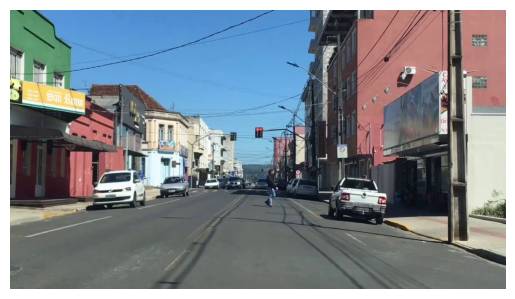

In [207]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [208]:
trash = 0.5
tresh_nms = 0.3

In [209]:
def predict(frame, net, output_layers, trash=0.5):
  blob = cv2.dnn.blobFromImage(frame, 0.00392, (416, 416), (0, 0, 0), True, crop=False)
  net.setInput(blob)
  outs = net.forward(output_layers)

  H, W = frame.shape[:2]

  class_ids = []
  confidences = []
  boxes = []

  for out in outs:
    for detection in out:
      
      scores = detection[5:]
      class_id = np.argmax(scores)
      confidence = scores[class_id]
      
      if confidence > trash:
        caixa = detection[:4] * np.array([W, H, W, H])
        x, y, w, h = caixa.astype(int)
        
        x = int(x - w / 2)
        y = int(y - h / 2)
        
        class_ids.append(class_id)
        confidences.append(float(confidence))
        boxes.append([x, y, w, h])
    
    return class_ids, confidences, boxes
  
def process(frame, names, class_ids, boxes, colors, confidences, trash=0.5, tresh_nms=0.3):
    class_ids_filtered = cv2.dnn.NMSBoxes(boxes, confidences, trash, tresh_nms)
    frame_copy = frame.copy()

    for filtred in class_ids_filtered:
      x, y, w, h = boxes[filtred]
      
      label = names[class_ids[filtred]]
      color = colors[class_ids[filtred]]

      fundo = np.zeros((frame_copy.shape), np.uint8)
      cv2.putText(fundo, label, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)
      fx, fy, fw, fh = cv2.boundingRect(fundo[:, :, 0])
      cv2.rectangle(frame_copy, (fx, fy), (fx + fw, fy + fh), color, -1)
      cv2.rectangle(frame_copy, (fx, fy), (fx + fw, fy + fh), color, 3)
      
      cv2.rectangle(frame_copy, (x, y), (x + w, y + h), color, 2)
      cv2.putText(frame_copy, label, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1)
      
    return frame_copy

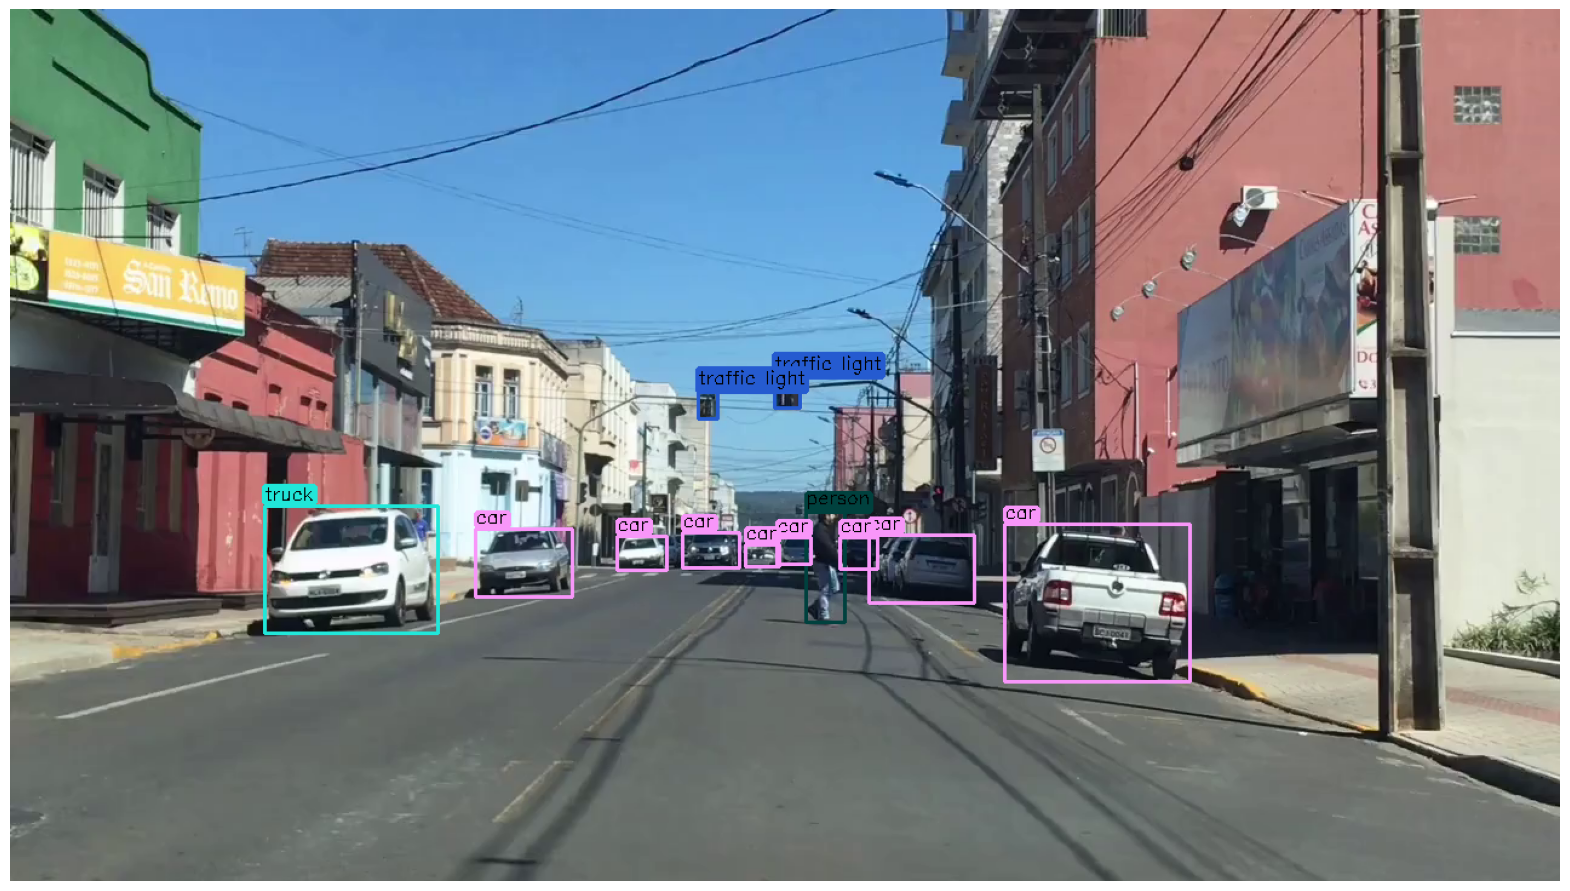

In [210]:
class_ids, confidences, boxes = predict(frame, net, output_layers, trash)
frame_copy = process(frame, names, class_ids, boxes, colors, confidences, trash, tresh_nms)
  
plt.figure(figsize=(20, 20))
plt.imshow(cv2.cvtColor(frame_copy, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

## Video preprocessing

In [ ]:
video = cv2.VideoCapture('video_teste02.mp4')
H, W = frame.shape[:2]

fourcc = cv2.VideoWriter_fourcc(*'XVID')
video_out = cv2.VideoWriter('video_out.avi', fourcc, 24.0, (W, H))

while True:
  ok, frame = video.read()
  if not ok:
    break

  time_process = time.time()
  
  class_ids, confidences, boxes = predict(frame, net, output_layers, trash)
  frame_copy = process(frame, names, class_ids, boxes, colors, confidences, trash, tresh_nms)

  time_process = time.time() - time_process
  
  cv2.putText(frame_copy, f'O tempo de processamento foi de {time_process:.2f} segundos', (10, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1)
  video_out.write(frame_copy)
  
video.release()
video_out.release()

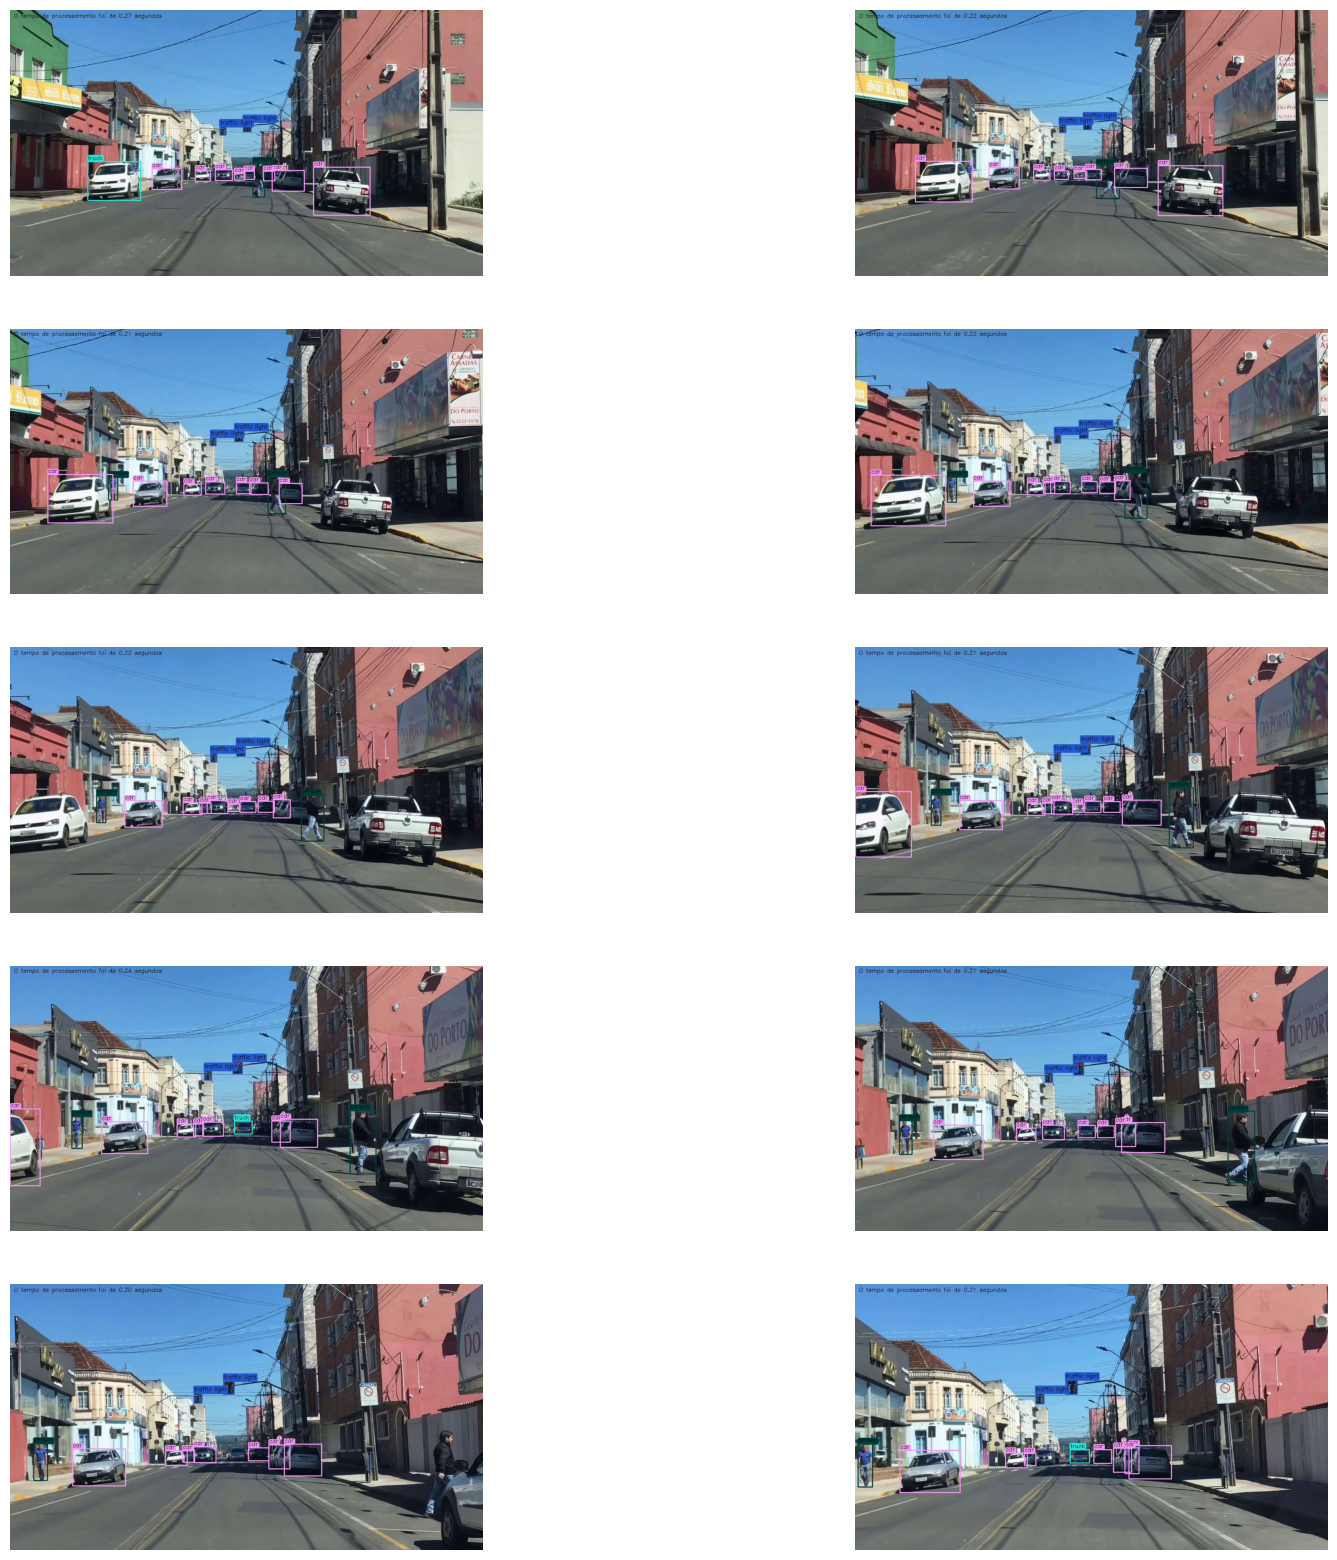

In [218]:
qtd_frames_total = 10
cap = cv2.VideoCapture('video_out.avi')
qtd_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

frames_choice = np.linspace(0, qtd_frames - 1, qtd_frames_total).astype(int)

frames = []
for frame_number in frames_choice:
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
    ret, frame = cap.read()
    if ret:
        frames.append(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

cap.release()

qtd_colunas = 2
qtd_linhas = 5

plt.figure(figsize=(20, 20))
for i, frame in enumerate(frames):
    plt.subplot(qtd_linhas, qtd_colunas, i + 1)
    plt.imshow(frame)
    plt.axis('off')
plt.show()
